In [2]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import IPython.display as IPythonAudio
import pyloudnorm as pyln
from volume_normalization import VolumeNormalizer
from vad_normalization import VADNormalizer

import sys
sys.path.append('..')
from audio import Audio

filtered_metadata_path = os.path.join("..", "data", "filtered_data_labeled.tsv")
audio_dir = os.path.join("..", "..", "filtered_clips")
df = pd.read_csv(filtered_metadata_path, sep="\t")

samples = 100
balanced_df = pd.DataFrame()
for cls in df['label'].unique():
    cls_df = df[df['label'] == cls]
    sampled = cls_df.sample(n=samples, random_state=42)  # Random sampling
    balanced_df = pd.concat([balanced_df, sampled])

### Load Audio File

In [3]:
def rerollAudio():
  random_sample = df.sample(1).iloc[0]
  audio_filename = random_sample['path']

  audio_file_path = os.path.join(audio_dir, audio_filename)
  audio, sr = librosa.load(audio_file_path, sr=None)
  print(f"Audio file: {audio_file_path}")
  return audio, sr

In [4]:
def show_difference(audio_before: np.ndarray, audio_after: np.ndarray, sr: int):
  # Plot original waveform
  plt.figure(figsize=(15, 6))

  # Plot original waveform
  plt.subplot(2, 1, 1)
  plt.plot(audio_before)
  plt.title("Original Waveform")
  plt.xlabel("Samples")
  plt.ylabel("Amplitude")

  # Plot processed waveform
  plt.subplot(2, 1, 2)
  plt.plot(audio_after)
  plt.title("Processed Waveform")
  plt.xlabel("Samples")
  plt.ylabel("Amplitude")

  plt.tight_layout()
  plt.show()

  IPythonAudio.display(IPythonAudio.Audio(audio_before, rate=sr))
  IPythonAudio.display(IPythonAudio.Audio(audio_after, rate=sr))

### Test Volume Normalization

  0%|          | 0/400 [00:00<?, ?it/s]

c:\Users\islam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
c:\Users\islam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
c:\Users\islam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
c:\Users\islam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
c:\Users\islam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clip

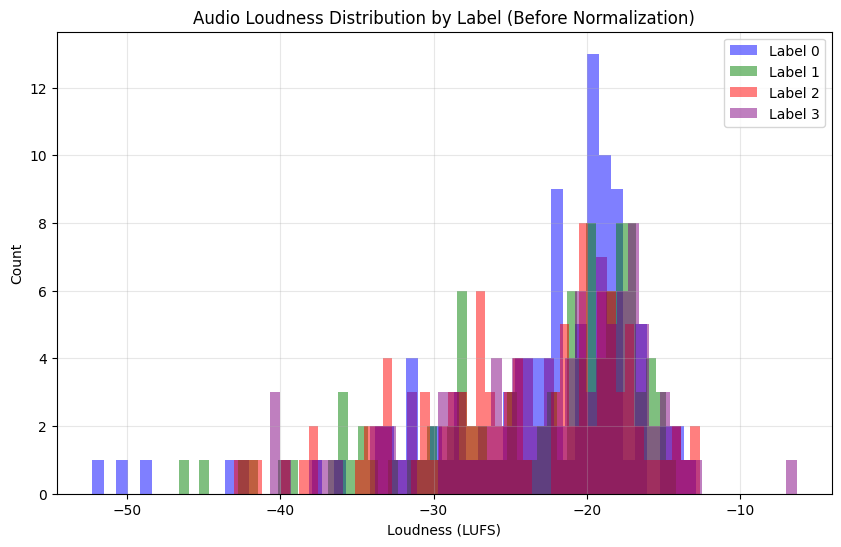

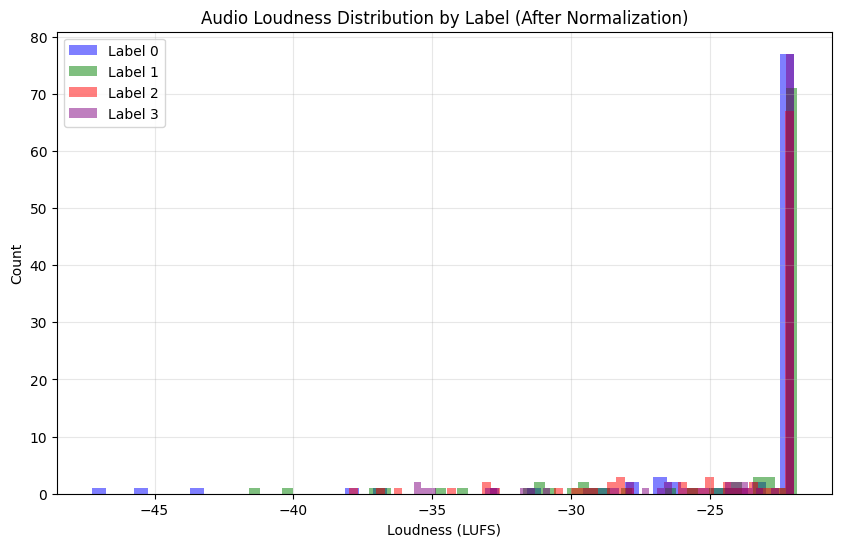

In [5]:
from tqdm.notebook import tqdm

volume_normalizer = VolumeNormalizer(-22, 5)

loudnesses_before = []
loudnesses_after = []
labels = []

# Process each audio file to extract loudness
for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
  try:
    audio_path = os.path.join(audio_dir, row['path'])
    audio, sr = librosa.load(audio_path, sr=None)
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio)
    loudnesses_before.append(loudness)

    normalized_audio = volume_normalizer.normalize_volume(Audio(audio, sr))
    
    loudness = meter.integrated_loudness(normalized_audio.data)
    loudnesses_after.append(loudness)

    labels.append(row['label'])
  except Exception as e:
    print(f"Error processing {row['path']}: {e}")

# Convert loudness and labels to a DataFrame for easier handling
loudness_df = pd.DataFrame({'loudness_before': loudnesses_before, 'loudness_after': loudnesses_after, 'label': labels})

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors for different labels
colors = ['blue', 'green', 'red', 'purple']

# Plot histogram for each label
for i, label in enumerate(sorted(loudness_df['label'].unique())):
  label_data = loudness_df[loudness_df['label'] == label]['loudness_before']
  plt.hist(label_data, bins=50, alpha=0.5, 
      label=f'Label {label}', color=colors[i % len(colors)])

plt.title('Audio Loudness Distribution by Label (Before Normalization)')
plt.xlabel('Loudness (LUFS)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.figure(figsize=(10, 6))

# Define colors for different labels
colors = ['blue', 'green', 'red', 'purple']

# Plot histogram for each label
for i, label in enumerate(sorted(loudness_df['label'].unique())):
  label_data = loudness_df[loudness_df['label'] == label]['loudness_after']
  plt.hist(label_data, bins=50, alpha=0.5, 
      label=f'Label {label}', color=colors[i % len(colors)])

plt.title('Audio Loudness Distribution by Label (After Normalization)')
plt.xlabel('Loudness (LUFS)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

Audio file: ..\..\filtered_clips\common_voice_en_29617.mp3


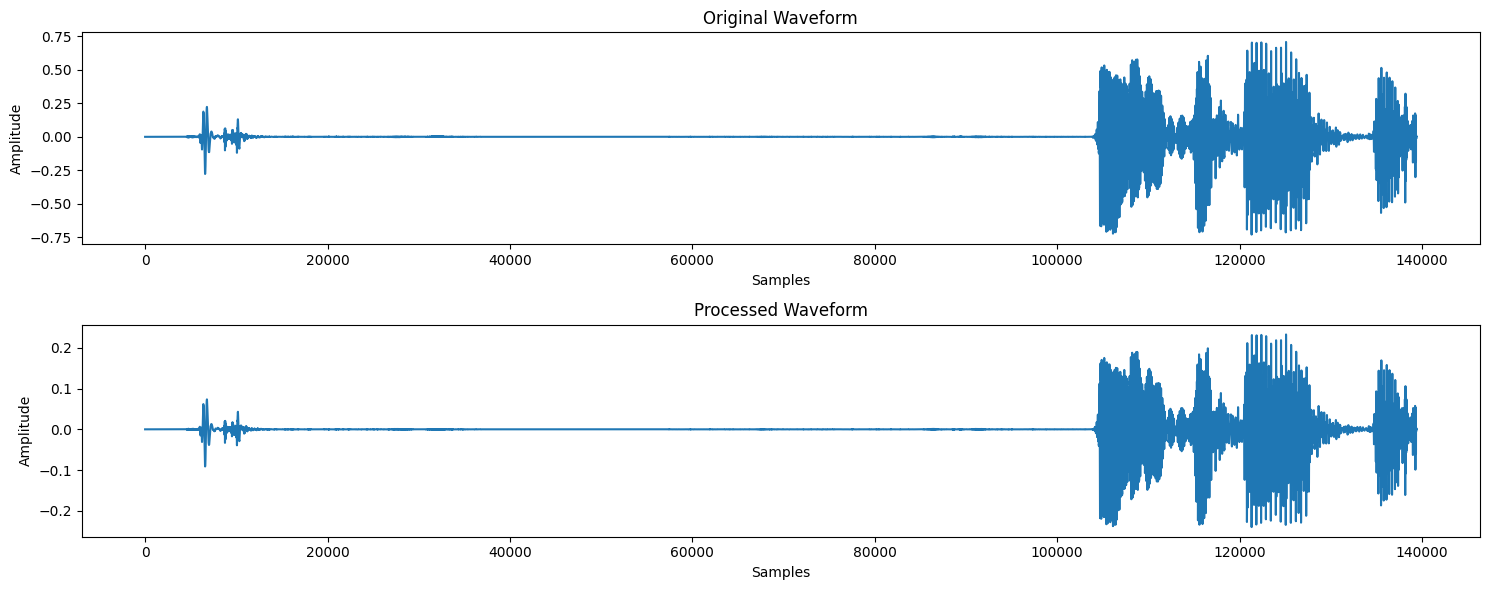

In [6]:
import soundfile as sf
import pyloudnorm as pyln

audio, sr = rerollAudio()

# measure the loudness first 
meter = pyln.Meter(sr) # create BS.1770 meter
loudness = meter.integrated_loudness(audio)

# loudness normalize audio to -12 dB LUFS
loudness_normalized_audio = pyln.normalize.loudness(audio, loudness, -25.0)

show_difference(audio, loudness_normalized_audio, sr)


### Test Voice Activity Detection

Audio file: ..\..\filtered_clips\common_voice_en_18658769.mp3


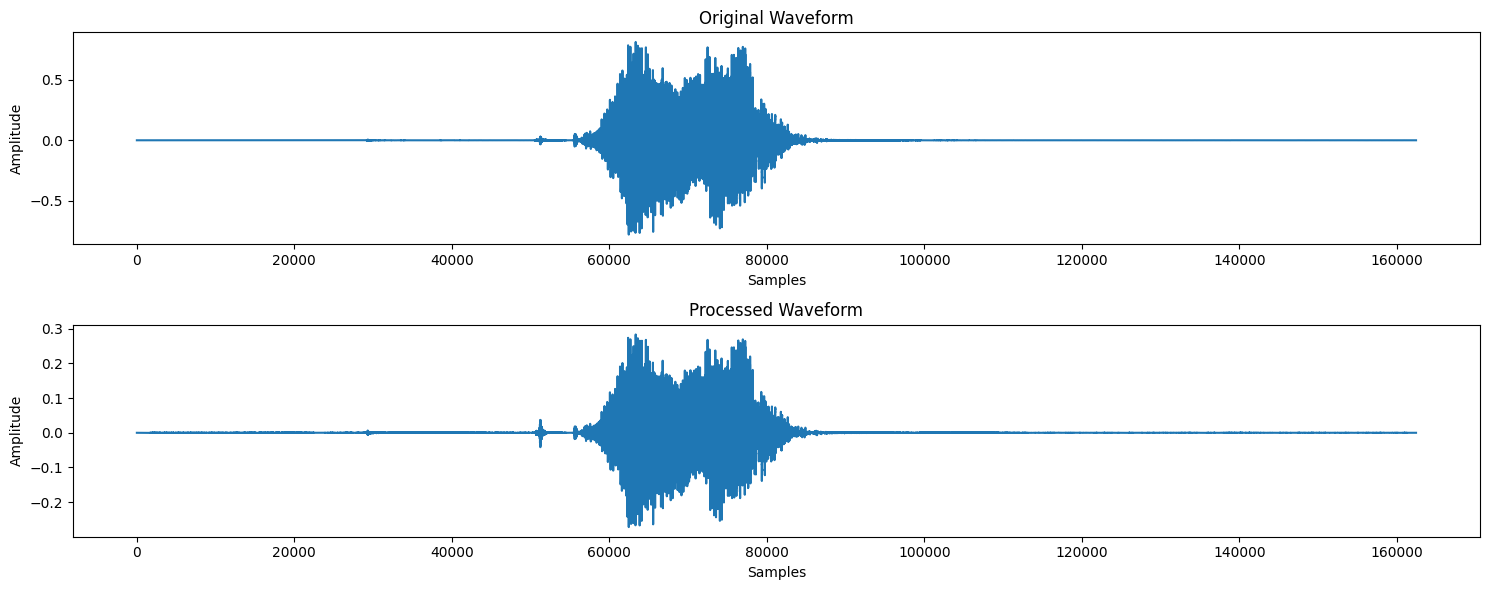

In [7]:
vad_normalizer = VADNormalizer()

audio, sr = rerollAudio()

normalized_audio = vad_normalizer.transform([Audio(audio, sr)])

show_difference(audio, normalized_audio[0].data, sr)

### Test Silence Removal

In [8]:
import librosa
import numpy as np

def amplitude_based_silence_removal(y, sr, threshold=0.05, frame_length=2048, hop_length=512):
    # Split into frames
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    frame_amplitudes = np.mean(np.abs(frames), axis=0)
    
    # Identify non-silent frames (boolean mask)
    non_silent = frame_amplitudes > (threshold * np.max(frame_amplitudes))
    
    # Convert frame indices to sample indices
    non_silent_indices = np.where(non_silent)[0]
    
    # Merge contiguous non-silent frames
    ranges = []
    start = None
    for idx in non_silent_indices:
        sample_start = idx * hop_length
        sample_end = sample_start + frame_length
        if start is None:
            start = sample_start
            current_end = sample_end
        else:
            if sample_start <= current_end:
                current_end = sample_end
            else:
                ranges.append((start, current_end))
                start = sample_start
                current_end = sample_end
    if start is not None:
        ranges.append((start, current_end))
    
    # Extract trimmed audio
    y_trimmed = np.concatenate([y[start:end] for (start, end) in ranges])
    
    return y_trimmed

trimmed = amplitude_based_silence_removal(audio, sr, threshold=0.005, frame_length=sr//2, hop_length=512)

IPythonAudio.display(IPythonAudio.Audio(trimmed, rate=sr))

### Test Preprocessing Pipeline

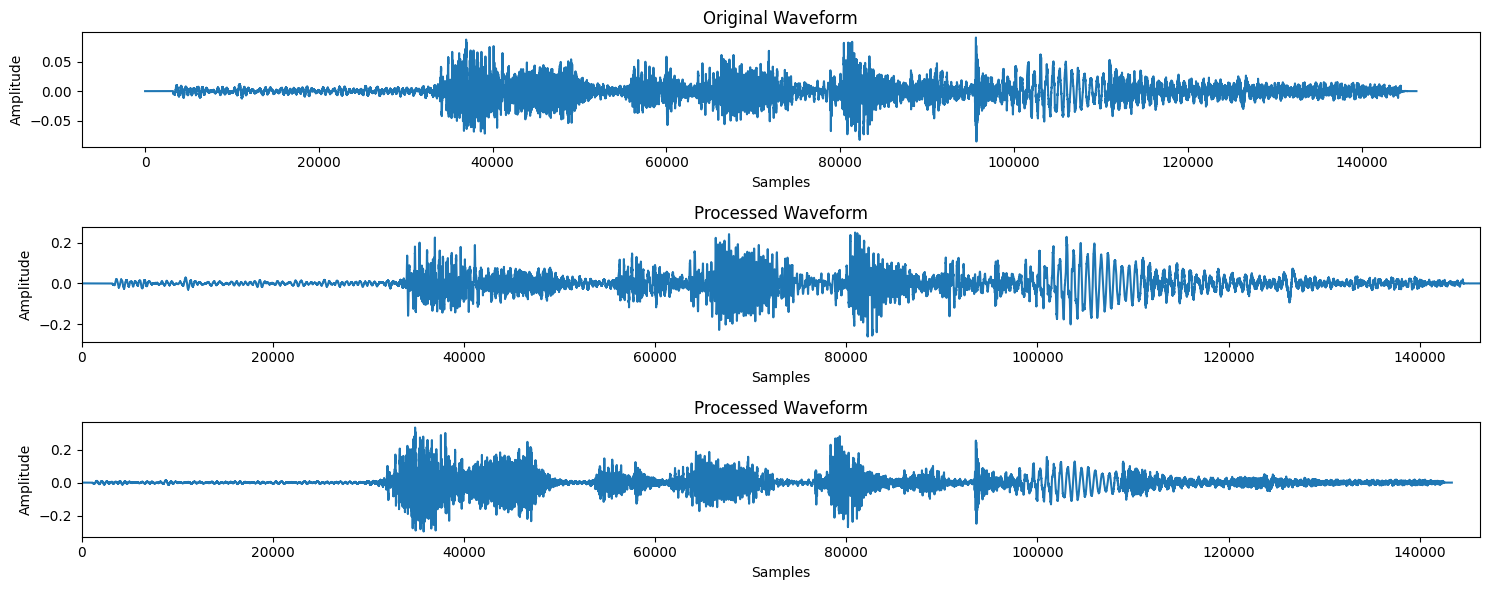

In [16]:
from pedalboard import *

# audio, sr = rerollAudio()
audio, sr = librosa.load('..\\..\\filtered_clips\\common_voice_en_16048960.mp3', sr=None)

new_audio = vad_normalizer.transform([Audio(audio, sr)])[0]
# noise_clip = new_audio.data[0:int(0.5 * sr)]
new_audio = nr.reduce_noise(new_audio.data, sr=new_audio.sampling_rate, prop_decrease=0.8, stationary=False, n_std_thresh_stationary=1.1)
new_audio = Audio(new_audio, sr=sr)
new_audio = amplitude_based_silence_removal(new_audio.data, sr=new_audio.sampling_rate, hop_length=2048, threshold=0.01)

board = Pedalboard([
    NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
    Compressor(threshold_db=-16, ratio=4),
    LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),
    Gain(gain_db=2)
])

effected = board(audio, sr)

plt.figure(figsize=(15, 6))

# Plot original waveform
plt.subplot(3, 1, 1)
plt.plot(audio)
plt.title("Original Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot processed waveform
plt.subplot(3, 1, 2)
plt.plot(effected)
plt.title("Processed Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.xlim(0, len(audio))  # Set x-axis limit to match the original waveform

plt.subplot(3, 1, 3)
plt.plot(new_audio)
plt.title("Processed Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.xlim(0, len(audio)) 

plt.tight_layout()
plt.show()

IPythonAudio.display(IPythonAudio.Audio(audio, rate=sr))
IPythonAudio.display(IPythonAudio.Audio(effected, rate=sr))
IPythonAudio.display(IPythonAudio.Audio(new_audio, rate=sr))